In [2]:
import numpy as np
import pandas as pd
import math

import seaborn as sns
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from scipy.stats import chi2_contingency
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [3]:
train = pd.read_csv('../data/train.csv', index_col='id')
test = pd.read_csv('../data/test.csv', index_col='id')
submission = pd.read_csv('../data/sample_submission.csv', index_col='id')

In [4]:
trainNotNull = train[train['Y18'].notnull()]
trainNotNull = trainNotNull.drop(['X04', 'X14', 'X16', 'X19', 'X36', 'Y00', 'Y01', 'Y02', 'Y03', 'Y04', 'Y05', 'Y06', 'Y07', 'Y08', 'Y09', 'Y10', 'Y11', 'Y12', 'Y13', 'Y14', 'Y15', 'Y16', 'Y17'], axis=1)
trainNotNull.head()

,X00,X01,X02,X03,X05,X06,X07,X08,X09,X10,...,X30,X31,X32,X33,X34,X35,X37,X38,X39,Y18
id,,,,,,,,,,,,,,,,,,,,,
4320,19.3,987.7,0.9,2.2,1007.7,988.0,20.8,1007.8,1007.4,0.0,...,87.6,18.0,18.7,1008.3,0.0,353.5,84.0,77.6,0.0,20.5
4321,19.0,987.6,1.9,2.2,1007.7,988.0,20.6,1007.8,1007.4,0.0,...,86.4,17.7,19.0,1008.3,0.0,303.1,84.4,79.2,0.0,20.5
4322,19.1,987.6,2.0,1.4,1007.8,988.1,20.5,1007.9,1007.4,0.0,...,85.7,17.4,19.2,1008.3,0.0,307.3,84.9,79.9,0.0,20.5
4323,19.2,987.7,1.8,1.5,1007.9,988.1,20.5,1007.9,1007.5,0.0,...,85.1,17.5,19.3,1008.4,0.0,315.6,84.9,80.7,0.0,20.5
4324,19.2,987.8,1.4,1.4,1007.9,988.1,20.5,1007.8,1007.6,0.0,...,84.9,17.4,19.5,1008.4,0.0,321.2,84.9,80.9,0.0,20.5


In [5]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

def get_model_cv_prediction(model, X_data, y_target):
    neg_mse_scores = cross_val_score(model, X_data, y_target, scoring="neg_mean_squared_error", cv = 5)
    rmse_scores = np.sqrt(-1 * neg_mse_scores)
    avg_rmse = np.mean(rmse_scores)
    print('##### ', model.__class__.__name__, ' #####')
    print(' 5 교차 검증의 평균 RMSE : {0:.3f} '.format(avg_rmse))

In [6]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

xgbr = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=1500,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

lgbmr = LGBMRegressor(colsample_bylevel= 0.5, colsample_bytree= 0.7, max_depth= 3, n_estimators= 1500)

In [7]:
columnList = trainNotNull.columns
target_var = ['Y18']
input_var = list(filter(lambda x:x != 'Y18', columnList))

X_features = trainNotNull[input_var]
y_target = trainNotNull[target_var]

In [8]:
models = [xgbr, lgbmr]

for model in models:
    get_model_cv_prediction(model, X_features, y_target)

[19:54:04] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:54:05] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:54:06] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:54:07] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:54:08] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
#####  XGBRegressor  #####
 5 교차 검증의 평균 RMSE : 1.621 
#####  LGBMRegressor  #####
 5 교차 검증의 평균 RMSE : 1.595 


In [9]:
## 왜곡된 데이터 확인

from scipy.stats import skew

features_index = X_features.dtypes[X_features.dtypes != 'object'].index
# features_index

skew_features = X_features[features_index].apply(lambda x: skew(x))
# skew_features

skew_features_top = skew_features[skew_features > 1]
skew_features_top

X10    3.706166
X21    4.041833
X39    2.300171
dtype: float64

In [10]:
## 왜곡이 심한 데이터 로그변환
trainNotNull[skew_features_top.index] = np.log1p(trainNotNull[skew_features_top.index])

In [11]:
trainNotNull

,X00,X01,X02,X03,X05,X06,X07,X08,X09,X10,...,X30,X31,X32,X33,X34,X35,X37,X38,X39,Y18
id,,,,,,,,,,,,,,,,,,,,,
4320,19.3,987.7,0.9,2.2,1007.7,988.0,20.8,1007.8,1007.4,0.000000,...,87.6,18.0,18.7,1008.3,0.00,353.5,84.0,77.6,0.000000,20.5
4321,19.0,987.6,1.9,2.2,1007.7,988.0,20.6,1007.8,1007.4,0.000000,...,86.4,17.7,19.0,1008.3,0.00,303.1,84.4,79.2,0.000000,20.5
4322,19.1,987.6,2.0,1.4,1007.8,988.1,20.5,1007.9,1007.4,0.000000,...,85.7,17.4,19.2,1008.3,0.00,307.3,84.9,79.9,0.000000,20.5
4323,19.2,987.7,1.8,1.5,1007.9,988.1,20.5,1007.9,1007.5,0.000000,...,85.1,17.5,19.3,1008.4,0.00,315.6,84.9,80.7,0.000000,20.5
4324,19.2,987.8,1.4,1.4,1007.9,988.1,20.5,1007.8,1007.6,0.000000,...,84.9,17.4,19.5,1008.4,0.00,321.2,84.9,80.9,0.000000,20.5
4325,19.0,987.9,1.5,1.2,1007.8,988.1,20.4,1008.0,1007.7,0.000000,...,84.9,17.4,19.6,1008.4,0.00,287.4,85.2,81.3,0.000000,20.5
4326,19.1,987.9,1.2,1.0,1007.8,988.1,20.3,1008.0,1007.7,0.000000,...,83.6,17.3,19.8,1008.3,0.00,330.5,85.2,80.8,0.000000,20.5
4327,19.3,987.8,0.7,0.6,1007.8,988.1,20.4,1008.0,1007.6,0.000000,...,84.0,17.3,19.7,1008.4,0.00,352.3,85.2,80.8,0.000000,20.5
4328,19.1,987.7,2.7,0.1,1007.7,988.1,20.4,1008.0,1007.5,0.000000,...,83.9,17.5,19.7,1008.4,0.00,305.1,85.3,80.6,0.000000,20.5


In [12]:
from sklearn.model_selection import GridSearchCV

param = {
    'max_depth':[2,3,4],
    'n_estimators':range(1000,2000,500),
    'colsample_bytree':[0.5,0.7,1],
    'colsample_bylevel':[0.5,0.7,1],
}
model = XGBRegressor()
grid_search = GridSearchCV(estimator=model, param_grid=param, cv=5, 
                           scoring='neg_mean_squared_error',
                           n_jobs=-1)

grid_search.fit(X_features, y_target)
print(grid_search.best_params_)
print(grid_search.best_estimator_)

[19:55:34] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
{'colsample_bylevel': 1, 'colsample_bytree': 0.7, 'max_depth': 3, 'n_estimators': 1500}
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=1500,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)


In [13]:
param = {
    'max_depth':[10,50,200],
    'num_leaves': [10, 128, 160],
    'min_child_samples': [60, 100, 200]
    
}
lgbm_model = LGBMRegressor()
lgbm_grid_search = GridSearchCV(estimator=lgbm_model, param_grid=param, cv=5, 
                           scoring='neg_mean_squared_error',
                           n_jobs=-1)

lgbm_grid_search.fit(X_features, y_target)
print(lgbm_grid_search.best_params_)
print(lgbm_grid_search.best_estimator_)

{'max_depth': 10, 'min_child_samples': 100, 'num_leaves': 10}
LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=10,
              min_child_samples=100, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=100, n_jobs=-1, num_leaves=10, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


In [14]:
X_features = trainNotNull[input_var]
y_target = trainNotNull[target_var]

In [15]:
for model in models:
    get_model_cv_prediction(model, X_features, y_target)

[19:55:44] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:55:46] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:55:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:55:48] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:55:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
#####  XGBRegressor  #####
 5 교차 검증의 평균 RMSE : 1.621 
#####  LGBMRegressor  #####
 5 교차 검증의 평균 RMSE : 1.595 


Text(0.5, 0, 'X39')

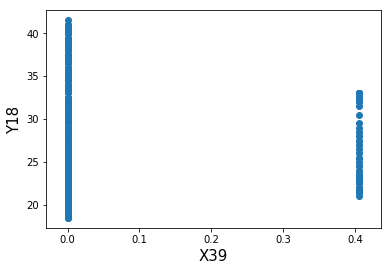

In [16]:
### 이상치 확인

# X10    3.706166
# X21    4.041833
# X39    2.300171

plt.scatter(x = trainNotNull['X39'], y = trainNotNull['Y18'])
plt.ylabel('Y18', fontsize=15)
plt.xlabel('X39', fontsize=15)


In [17]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds):
    kf = KFold(n_splits=n_folds, shuffle=False, random_state=0)
    train_fold_pred = np.zeros((X_train_n.shape[0], 1))
    test_pred = np.zeros((X_test_n.shape[0], n_folds))
    print(model.__class__.__name__, ' model 시작 ')

    for folder_counter, (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        print('\t 폴드 세트: ', folder_counter, ' 시작 ')
        X_tr = X_train_n[train_index]
        y_tr = y_train_n[train_index]
        X_te = X_train_n[valid_index]

        model.fit(X_tr, y_tr)

        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1, 1)
        test_pred[:, folder_counter] = model.predict(X_test_n)

    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1, 1)

    return train_fold_pred, test_pred_mean

In [18]:
lasso_params = {'alpha': [0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1, 5, 10]}

lasso_grid_search = GridSearchCV(estimator=lgbm_model, param_grid=lasso_params, cv=5, scoring='neg_mean_squared_error')
lasso_grid_search.fit(X_features, y_target)

lasso_rmse = np.sqrt(-1*lasso_grid_search.best_score_)
print(lasso_rmse)
print(lasso_grid_search.best_params_)

1.7296126331102917
{'alpha': 0.001}


In [20]:
from sklearn.linear_model import Lasso
lasso_real_reg = Lasso(alpha= 0.001)

In [21]:
from sklearn.linear_model import Lasso

lasso_reg = Lasso()

models = [xgbr, lgbmr, lasso_real_reg]

for model in models:
    get_model_cv_prediction(model, X_features, y_target)

[19:59:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:59:39] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:59:41] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:59:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[19:59:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
#####  XGBRegressor  #####
 5 교차 검증의 평균 RMSE : 1.621 
#####  LGBMRegressor  #####
 5 교차 검증의 평균 RMSE : 1.595 
#####  Lasso  #####
 5 교차 검증의 평균 RMSE : 3.687 


In [22]:
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.3, random_state=0)

In [23]:
X_train_n = X_train.values
X_test_n = X_test.values
y_train_n = y_train.values

lasso_train, lasso_test = get_stacking_base_datasets(lasso_real_reg, X_train_n, y_train_n, X_test_n, 5)
xgb_train, xgb_test = get_stacking_base_datasets(xgbr, X_train_n, y_train_n, X_test_n, 5)
lgbm_train, lgbm_test = get_stacking_base_datasets(lgbmr, X_train_n, y_train_n, X_test_n, 5)

Lasso  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
XGBRegressor  model 시작 
	 폴드 세트:  0  시작 
[19:59:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	 폴드 세트:  1  시작 
[19:59:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	 폴드 세트:  2  시작 
[19:59:51] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	 폴드 세트:  3  시작 
[19:59:52] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	 폴드 세트:  4  시작 
[19:59:53] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated

In [24]:
from sklearn.metrics import mean_squared_error

Stack_final_X_train = np.concatenate((lasso_train,xgb_train,lgbm_train), axis=1)
Stack_final_X_test = np.concatenate((lasso_test,xgb_test,lgbm_test), axis=1)

meta_model_lasso = Lasso(alpha=0.0005)

meta_model_lasso.fit(Stack_final_X_train, y_train)
final = meta_model_lasso.predict(Stack_final_X_test)
mse = mean_squared_error(y_test, final)
rmse = np.sqrt(mse)
print('스태킹 회귀 모델 최종 RMSE :: ',rmse)

스태킹 회귀 모델 최종 RMSE ::  0.7923827927402464


In [31]:
len(X_train_n)
len(X_test_n)
len(y_train_n)
print(len(X_train_n),len(X_test_n),len(y_train_n))

302 130 302


In [32]:
# test.values
testNotNull = test.drop(['X04', 'X14', 'X16', 'X19', 'X36'], axis=1)
testNotNull.values

array([[1.870e+01, 9.874e+02, 1.500e+00, ..., 8.400e+01, 5.990e+01,
        0.000e+00],
       [1.880e+01, 9.874e+02, 1.100e+00, ..., 8.400e+01, 6.050e+01,
        0.000e+00],
       [1.900e+01, 9.874e+02, 1.300e+00, ..., 8.500e+01, 6.080e+01,
        0.000e+00],
       ...,
       [2.560e+01, 9.932e+02, 3.800e+00, ..., 7.920e+01, 6.830e+01,
        5.000e-01],
       [2.550e+01, 9.932e+02, 2.400e+00, ..., 8.010e+01, 6.880e+01,
        5.000e-01],
       [2.540e+01, 9.932e+02, 3.000e+00, ..., 8.020e+01, 6.890e+01,
        5.000e-01]])

In [33]:
X_train_n = trainNotNull[input_var].values
X_test_n = testNotNull.values
y_train_n = trainNotNull[target_var].values

In [34]:
print(len(X_train_n), len(X_test_n), len(y_train_n))

432 11520 432


In [35]:
lasso_train, lasso_test = get_stacking_base_datasets(lasso_real_reg, X_train_n, y_train_n, X_test_n, 5)
xgb_train, xgb_test = get_stacking_base_datasets(xgbr, X_train_n, y_train_n, X_test_n, 5)
lgbm_train, lgbm_test = get_stacking_base_datasets(lgbmr, X_train_n, y_train_n, X_test_n, 5)

Lasso  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
XGBRegressor  model 시작 
	 폴드 세트:  0  시작 
[20:04:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	 폴드 세트:  1  시작 
[20:04:20] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	 폴드 세트:  2  시작 
[20:04:21] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	 폴드 세트:  3  시작 
[20:04:23] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
	 폴드 세트:  4  시작 
[20:04:24] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated

In [39]:
Stack_final_X_train = np.concatenate((lasso_train,xgb_train,lgbm_train), axis=1)
Stack_final_X_test = np.concatenate((lasso_test,xgb_test,lgbm_test), axis=1)

len(Stack_final_X_train)
len(Stack_final_X_test)
len(trainNotNull[target_var].values)
meta_model_lasso = Lasso(alpha=0.0005)


meta_model_lasso.fit(Stack_final_X_train, trainNotNull[target_var].values)
final = meta_model_lasso.predict(Stack_final_X_test)


# mse = mean_squared_error(y_test, final)
# rmse = np.sqrt(mse)
# print('스태킹 회귀 모델 최종 RMSE :: ',rmse)

In [40]:
final

array([21.02001554, 21.06217307, 21.11023725, ..., 26.75825691,
       26.55384654, 26.50991625])

In [42]:
outputDf = pd.DataFrame()
outputDf['id'] = test.index
outputDf['Y18'] = final

In [43]:
outputDf.to_csv('submission.csv', index=False)